We are going to provide a simple qualitative statistical test to measure change in a scene. It is inspired by the more complex work of [Stephenson et al.](https://github.com/olliestephenson).

Here is the rough idea. Let $\{X_1, ..., X_n, X_{n+1}\}$ be a time series. Our goal is to determine change at $X_{n+1}$ let 
$$
\mu_j = \frac 1 j \sum_{i \leq j} X_i.
$$
Then, $\mu_j$ is the empirical mean at $j$ in the time-series. Similarly, we have:
$$
\sigma_j = \sqrt{\frac 1 {j-1} \sum_{i \leq j} X_i - \mu_j}
$$
where we have used the unbiased formulat for [sample variance](https://en.wikipedia.org/wiki/Variance#Unbiased_sample_variance).

If we assume normality, we have a z-score metric $M$ define as:
$$
M_{j} := \frac{X_{j} - \mu_{j-1}}{\sigma_{j-1}}.
$$
Above, our sample statistics at index $j$ are computed on indices $i$ with $i < j$. We can then define the threshold statistically as change that exceeds a certain amount. Specifically, we can empirically say that those pixels that are $|M_{j}| > 3$ exceed three standard deviations when statistics are aggregated in the temporal dimension.

Below, we use (TV) despeckled imagery to construct our time-series. We explore the affect of restricting our analysis to particular land cover classes based on ESA World Cover. We also made some very coarse empirical assumptions. This is primarily to prototype and baseline such methods.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import rasterio
import geopandas as gpd
from pathlib import Path
from tqdm import tqdm
from tile_mate import get_raster_from_tiles
from rasterio.warp import transform_bounds
from rasterio.crs import CRS
from dem_stitcher.rio_tools import reproject_arr_to_match_profile
import matplotlib.pyplot as plt

# Load Data

In [3]:
BURST_ID = 'T064-135524-IW1'.upper().replace('-', '_')

In [4]:
ts_dir = Path('burst_time_series')
burst_dir = ts_dir / BURST_ID
assert burst_dir.exists()

In [5]:
metadata_geojson = burst_dir / f'metadata_{BURST_ID}_rtc_ts.geojson'

In [6]:
df_meta = gpd.read_file(metadata_geojson)
df_meta.head()

,opera_id,start_time,url_vh,url_vv,track_number,local_path_vv,local_path_vh,local_path_vh_tv,local_path_vv_tv,geometry
0,OPERA_L2_RTC-S1_T064-135524-IW1_20200229T01503...,2020-02-29 01:50:38+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98182 34.68055, -118.04924 34.8..."
1,OPERA_L2_RTC-S1_T064-135524-IW1_20200312T01503...,2020-03-12 01:50:38+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98250 34.68103, -118.04995 34.8..."
2,OPERA_L2_RTC-S1_T064-135524-IW1_20200324T01503...,2020-03-24 01:50:38+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98190 34.68043, -118.04933 34.8..."
3,OPERA_L2_RTC-S1_T064-135524-IW1_20200417T01503...,2020-04-17 01:50:39+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98167 34.68114, -118.04926 34.8..."
4,OPERA_L2_RTC-S1_T064-135524-IW1_20200429T01504...,2020-04-29 01:50:40+00:00,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,https://datapool.asf.alaska.edu/RTC/OPERA-S1/O...,64,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,burst_time_series/T064_135524_IW1/OPERA_L2_RTC...,"POLYGON ((-118.98164 34.68052, -118.04921 34.8..."


In [7]:
with rasterio.open(df_meta.local_path_vh.tolist()[0]) as ds:
    p_rtc = ds.profile
    bounds = ds.bounds
bounds, p_rtc

(BoundingBox(left=307350.0, bottom=3833490.0, right=406500.0, top=3880230.0),
 {'driver': 'GTiff', 'dtype': 'float32', 'nodata': nan, 'width': 3305, 'height': 1558, 'count': 1, 'crs': CRS.from_epsg(32611), 'transform': Affine(30.0, 0.0, 307350.0,
        0.0, -30.0, 3880230.0), 'blockxsize': 512, 'blockysize': 512, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'})

In [8]:
bounds_4326 = transform_bounds(p_rtc['crs'], CRS.from_epsg(4326), *bounds)
bounds_4326

(-119.1122238122238,
 34.625213902341116,
 -118.02016019842533,
 35.060473381903385)

In [9]:
bounds_4326 = transform_bounds(p_rtc['crs'], CRS.from_epsg(4326), *bounds)
bounds_4326

(-119.1122238122238,
 34.625213902341116,
 -118.02016019842533,
 35.060473381903385)

In [10]:
X_occ, p_occ = get_raster_from_tiles(bounds_4326, tile_shortname='pekel_water_occ_2021')

Reading tile imagery: 100%|██████████████| 1/1 [00:00<00:00,  1.87it/s]


In [11]:
X_occ = X_occ.astype(np.float32)
p_occ['dtype'] = 'float32'
X_occ_r, _ = reproject_arr_to_match_profile(X_occ, p_occ, p_rtc, resampling='bilinear')
WATER_MASK = (X_occ_r > 95)[0, ...]

# ESA World Cover

In [12]:
X_lc, p_lc = get_raster_from_tiles(bounds_4326, tile_shortname='esa_world_cover_2021')

Reading tile imagery: 100%|██████████████| 1/1 [00:05<00:00,  5.08s/it]


In [13]:
from resample import resample_multiclass_arr_to_majority_label
X_lc_r = resample_multiclass_arr_to_majority_label(X_lc, p_lc, p_rtc)

100%|████████████████████████████████████| 8/8 [00:04<00:00,  1.92it/s]


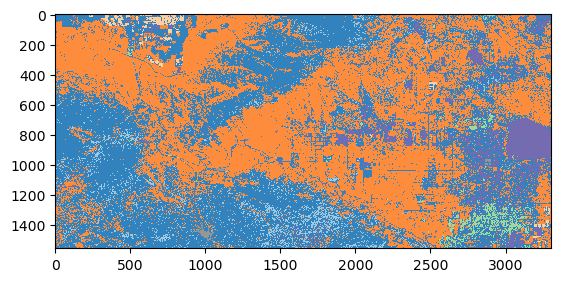

In [14]:
plt.imshow(X_lc_r, cmap='tab20c', interpolation='none', vmax=90)

(array([0.000000e+00, 2.253680e+06, 1.745220e+05, 2.350122e+06,
        3.378100e+04, 5.824100e+04, 2.690650e+05, 0.000000e+00,
        9.745000e+03, 3.400000e+01, 0.000000e+00]),
 array([  0.        ,   9.09090909,  18.18181818,  27.27272727,
         36.36363636,  45.45454545,  54.54545455,  63.63636364,
         72.72727273,  81.81818182,  90.90909091, 100.        ]),
 <BarContainer object of 11 artists>)

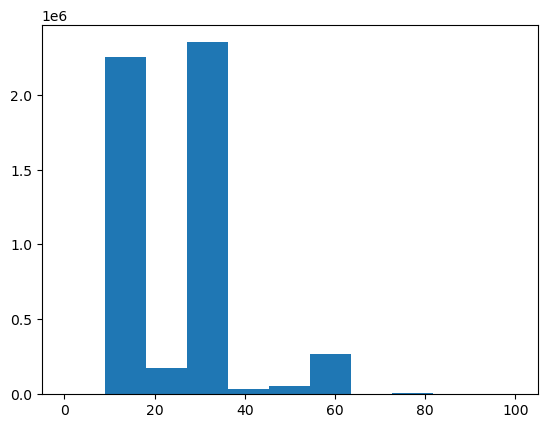

In [15]:
plt.hist(X_lc_r.ravel(), range=(0, 100), bins=11)

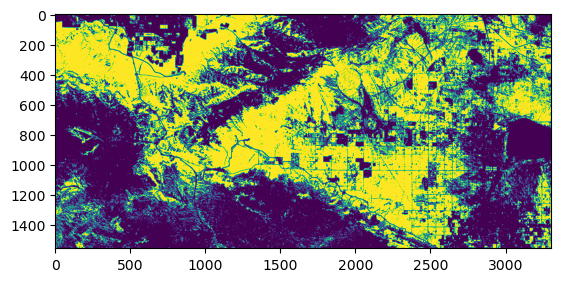

In [41]:
plt.imshow(X_lc_r == 30)

## Backscatter data

In [37]:
def open_one(path: str, land_cover_class=None) -> tuple:
    with rasterio.open(path) as ds:
        X = ds.read(1)
        p = ds.profile
    LC_MASK = np.ones(WATER_MASK.shape, dtype=bool) if land_cover_class is None else (X_lc_r != land_cover_class)
    X[WATER_MASK | (LC_MASK)] = np.nan
    ## Clip
    if '_VV.tif' == path[-7:]:
        X = np.clip(X, 0, 1)
    else:
        X = np.clip(X, 0, .5)
    return X, p

In [42]:
LC = 30
arrs_vv_tv, profiles = zip(*[open_one(p, land_cover_class=LC) for p in tqdm(df_meta.local_path_vv_tv)])
arrs_vh_tv, profiles = zip(*[open_one(p, land_cover_class=LC) for p in tqdm(df_meta.local_path_vh_tv)])

100%|████████████████████████████████| 115/115 [00:04<00:00, 28.11it/s]


# Z-score First pass

## 1 variable

Below you can toggle betwee `VV` and `VH`

In [70]:
time_series_arrs = arrs_vv_tv[:]
len(time_series_arrs)

115

We expose these parameters depending on which index you want $N+1$ to be `NP1_IND` (must be negative number since we start from the end. Also, the `LOOKBACK_SIZE` is just how many previous arrays we want to use (with `None` meaning include them all).

In [71]:
LOOKBACK_SIZE = None
NP1_IND = -1

if LOOKBACK_SIZE is not None:
    assert LOOKBACK_SIZE > 5
assert NP1_IND < 0

In [72]:
ind = np.s_[:NP1_IND] if LOOKBACK_SIZE is None else np.s_[-LOOKBACK_SIZE + NP1_IND: NP1_IND]
ts_prev = np.stack(time_series_arrs[ind], axis=-1)

This rescales each array spatially so that we have the same mean and standard deviation across the entire scene. *This could potentially be problematic*. 

In [73]:
mu_all = np.nanmean(ts_prev)
std_all = np.nanstd(ts_prev)
time_series_arrs_norm = [(arr - np.nanmean(arr)) / np.nanstd(arr) * std_all  + mu_all for arr in time_series_arrs]

In [74]:
print(ts_prev.shape)
ts_prev_norm = np.stack(time_series_arrs_norm[ind], axis=-1)
mu_n = np.nanmean(ts_prev_norm, axis=-1)
sigma_n = np.nanstd(ts_prev_norm, axis=-1)

diff = time_series_arrs_norm[-1] - mu_n
M_np1 = diff / (sigma_n)

(1558, 3305, 114)


/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_17465/3811774141.py:3: RuntimeWarning: Mean of empty slice
  mu_n = np.nanmean(ts_prev_norm, axis=-1)
/Users/cmarshak/miniforge3/envs/dist-s1/lib/python3.12/site-packages/numpy/lib/nanfunctions.py:1879: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\m'
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_17465/3474148029.py:5: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title('$\mu_{n}$')
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_17465/3474148029.py:10: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title('$\sigma_{n}$')
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_17465/3474148029.py:25: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title('$X_{n+1} - \mu_n$')


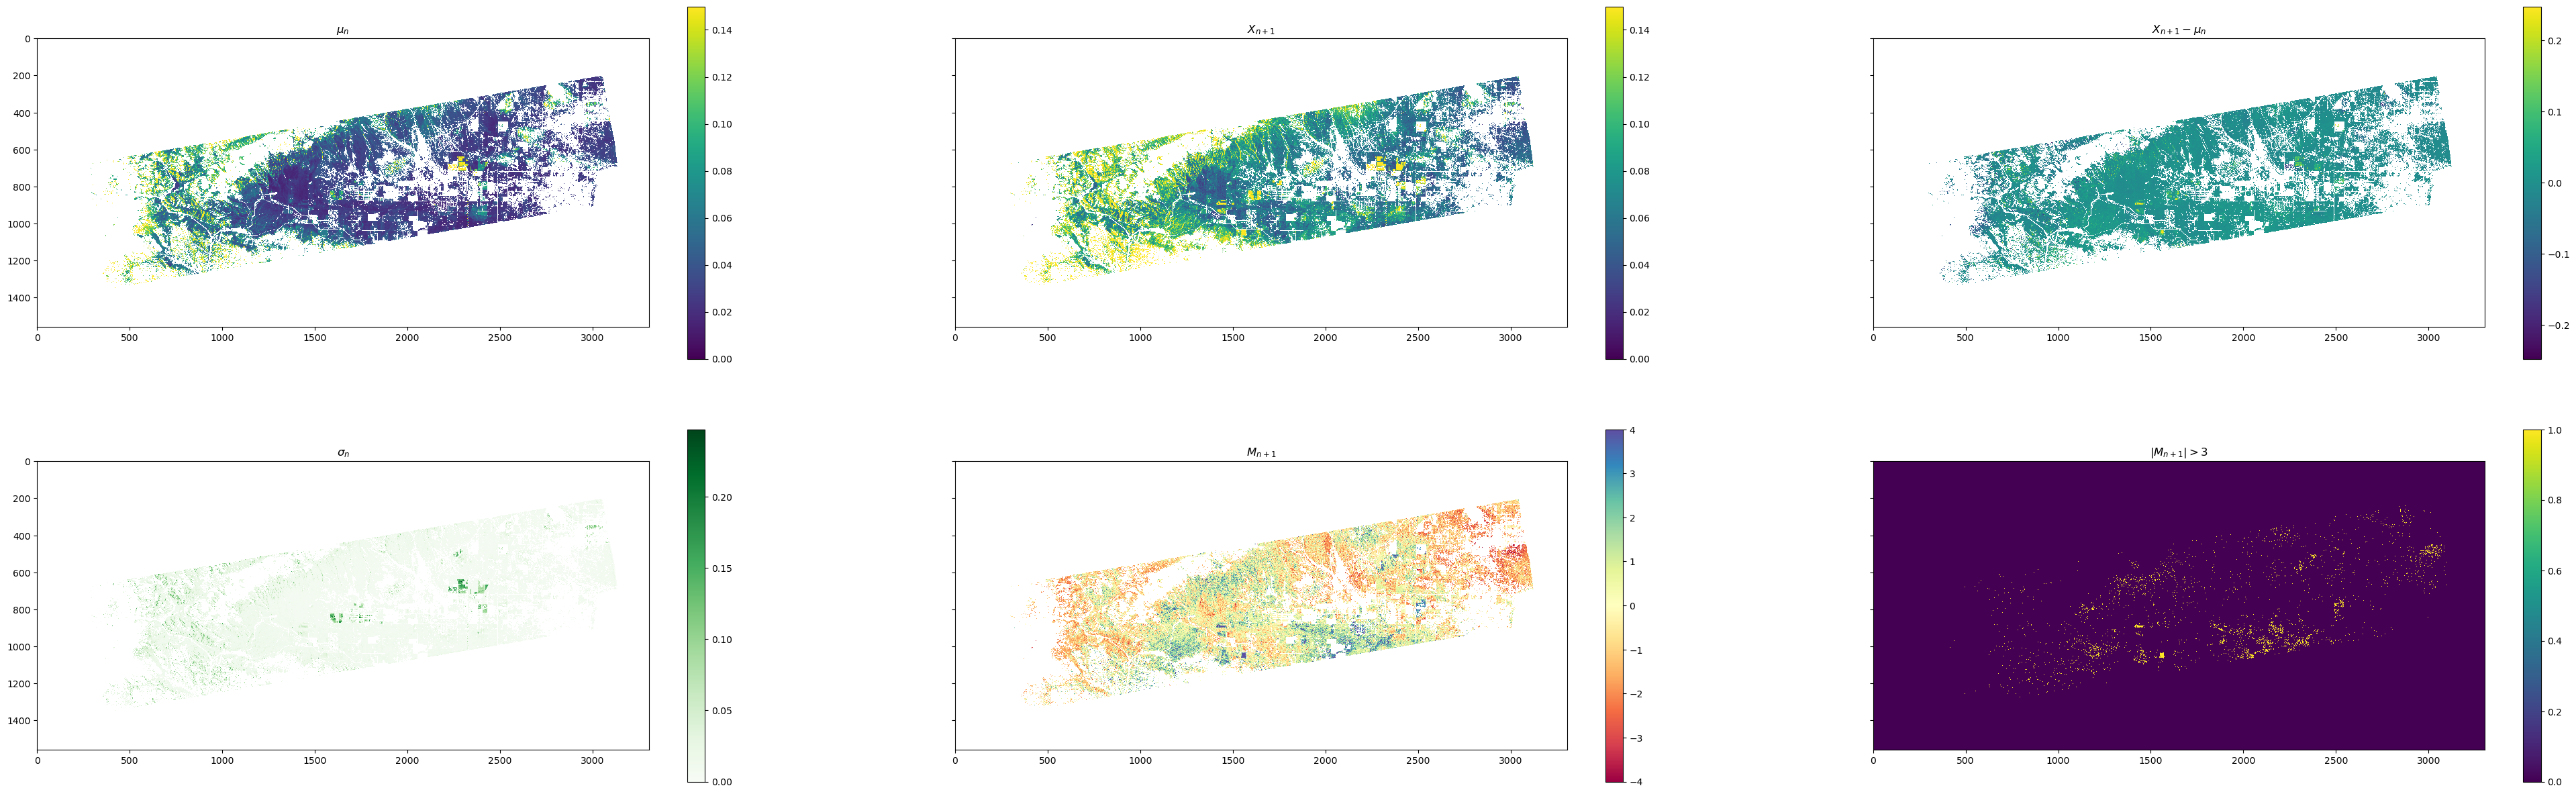

In [75]:
fig, axs = plt.subplots(2, 3, figsize=(50,15), sharey=True, dpi=100)

b_vmax = .15
ax = axs[0, 0]
ax.set_title('$\mu_{n}$')
im = ax.imshow(mu_n, vmin=0, vmax=b_vmax, interpolation='none')
fig.colorbar(im, ax=ax)

ax = axs[1, 0]
ax.set_title('$\sigma_{n}$')
im = ax.imshow(sigma_n, cmap='Greens', interpolation='none')
fig.colorbar(im, ax=ax)

ax = axs[0, 1]
ax.set_title('$X_{n+1}$')
im = ax.imshow(time_series_arrs[-1], vmin=0, vmax=b_vmax, interpolation='none')
fig.colorbar(im, ax=ax)

ax = axs[1, 1]
ax.set_title('$M_{n+1}$')
im = ax.imshow(M_np1, vmin=-4, vmax=4, cmap='Spectral', interpolation='none')
fig.colorbar(im, ax=ax)

ax = axs[0, 2]
ax.set_title('$X_{n+1} - \mu_n$')
s_max = np.nanmax(sigma_n)
im = ax.imshow(diff, vmin=-s_max, vmax=s_max, interpolation='none')
fig.colorbar(im, ax=ax)

ax = axs[1, 2]
ax.set_title('$|M_{n+1}| > 3$')
im = ax.imshow(np.abs(M_np1) > 3, interpolation='none')
fig.colorbar(im, ax=ax)

## Serialize

In [91]:
analysis_dir = Path(df_meta.local_path_vv_tv.tolist()[NP1_IND]).parent
analysis_dir

PosixPath('burst_time_series/T064_135524_IW1/OPERA_L2_RTC-S1_T064-135524-IW1_20240220T015100Z_20240220T081334Z_S1A_30_v1.0')

In [93]:
with rasterio.open(analysis_dir / 'mu.tif', 'w', **p_rtc) as ds:
    ds.write(mu_n, 1)


C = (np.abs(M_np1) > 3)
p_change = p_rtc.copy()
p_change['dtype'] = 'uint8'
p_change['nodata'] = 0
with rasterio.open(analysis_dir / 'change.tif', 'w', **p_change) as ds:
    ds.write(C, 1)

## Histograms

### Spatial histograms

$X_{n+1} - \mu_n$

(array([   506.,    638.,    691.,    819.,    972.,   1173.,   1408.,
          1703.,   2106.,   2513.,   3077.,   3602.,   4489.,   5482.,
          6728.,   8276.,  10522.,  14046.,  18622.,  28164.,  45018.,
         70704.,  98501., 118975., 121891., 108948.,  88673.,  66757.,
         47757.,  33097.,  22786.,  15979.,  11812.,   8612.,   6794.,
          5365.,   4211.,   3413.,   2883.,   2453.,   2243.,   1942.,
          1800.,   1594.,   1474.,   1311.,   1274.,   1137.,   1099.,
           903.]),
 array([-0.1  , -0.096, -0.092, -0.088, -0.084, -0.08 , -0.076, -0.072,
        -0.068, -0.064, -0.06 , -0.056, -0.052, -0.048, -0.044, -0.04 ,
        -0.036, -0.032, -0.028, -0.024, -0.02 , -0.016, -0.012, -0.008,
        -0.004,  0.   ,  0.004,  0.008,  0.012,  0.016,  0.02 ,  0.024,
         0.028,  0.032,  0.036,  0.04 ,  0.044,  0.048,  0.052,  0.056,
         0.06 ,  0.064,  0.068,  0.072,  0.076,  0.08 ,  0.084,  0.088,
         0.092,  0.096,  0.1  ]),
 <BarContainer obj

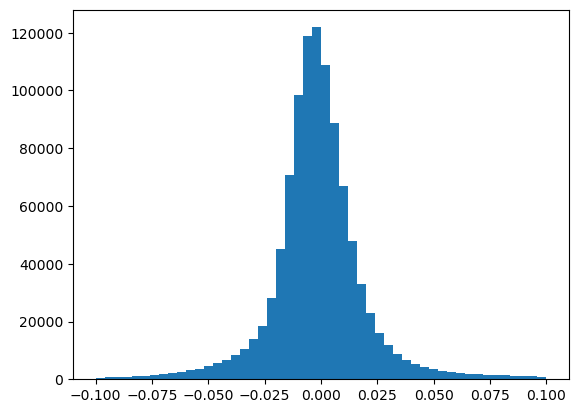

In [76]:
plt.hist(diff[~np.isnan(diff)], bins=50, range=(-.1, .1))

$\sigma_n$

(array([2.0460e+03, 2.9000e+01, 4.5000e+01, 3.1000e+01, 4.1000e+01,
        5.5000e+01, 4.1000e+01, 5.7000e+01, 8.5000e+01, 5.2800e+02,
        2.2390e+03, 6.8550e+03, 1.5565e+04, 2.8782e+04, 4.3362e+04,
        5.5611e+04, 6.3867e+04, 6.6198e+04, 6.2645e+04, 5.6851e+04,
        4.9597e+04, 4.2985e+04, 3.7456e+04, 3.2663e+04, 2.8755e+04,
        2.5768e+04, 2.3139e+04, 2.0929e+04, 1.9439e+04, 1.7735e+04,
        1.6022e+04, 1.5064e+04, 1.3637e+04, 1.2760e+04, 1.2086e+04,
        1.1259e+04, 1.0462e+04, 9.8480e+03, 9.1830e+03, 8.6280e+03,
        8.1300e+03, 7.8700e+03, 7.1920e+03, 6.9270e+03, 6.5880e+03,
        6.2520e+03, 5.9830e+03, 5.5650e+03, 5.3330e+03, 5.1460e+03]),
 array([0.    , 0.0004, 0.0008, 0.0012, 0.0016, 0.002 , 0.0024, 0.0028,
        0.0032, 0.0036, 0.004 , 0.0044, 0.0048, 0.0052, 0.0056, 0.006 ,
        0.0064, 0.0068, 0.0072, 0.0076, 0.008 , 0.0084, 0.0088, 0.0092,
        0.0096, 0.01  , 0.0104, 0.0108, 0.0112, 0.0116, 0.012 , 0.0124,
        0.0128, 0.0132, 0.0136

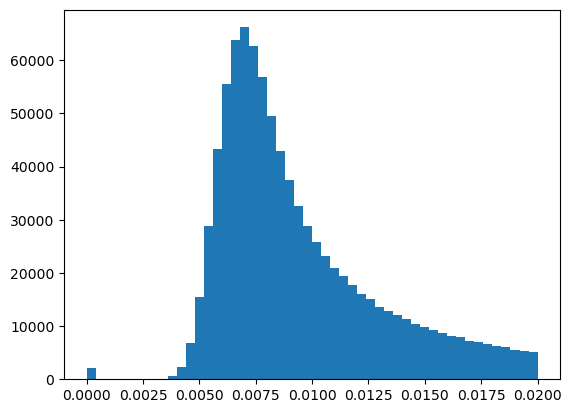

In [77]:
plt.hist(sigma_n[~np.isnan(sigma_n)], bins=50, range=(-.0, .02))

$M_{n+1}$

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        2.0000e+00, 1.1000e+01, 3.1000e+01, 5.6000e+01, 1.6200e+02,
        3.3300e+02, 7.2800e+02, 1.6030e+03, 3.4940e+03, 6.7620e+03,
        1.2483e+04, 2.1265e+04, 3.2797e+04, 4.7128e+04, 6.0051e+04,
        6.8998e+04, 7.6075e+04, 8.0643e+04, 8.2319e+04, 8.0417e+04,
        7.4930e+04, 6.8524e+04, 6.1356e+04, 5.2854e+04, 4.3892e+04,
        3.5820e+04, 2.8794e+04, 2.2456e+04, 1.7533e+04, 1.3444e+04,
        1.0142e+04, 7.5100e+03, 5.4150e+03, 3.9450e+03, 2.9650e+03,
        2.1480e+03, 1.5630e+03, 1.1480e+03, 8.3700e+02, 6.1600e+02,
        4.2600e+02, 3.3300e+02, 2.2400e+02, 2.0000e+02, 1.3500e+02]),
 array([-7.00000000e+00, -6.71999979e+00, -6.44000006e+00, -6.15999985e+00,
        -5.88000011e+00, -5.59999990e+00, -5.32000017e+00, -5.03999996e+00,
        -4.76000023e+00, -4.48000002e+00, -4.19999981e+00, -3.92000008e+00,
        -3.64000010e+00, -3.35999990e+00, -3.07999992e+00, -2.79999995e+00,
        -2.519

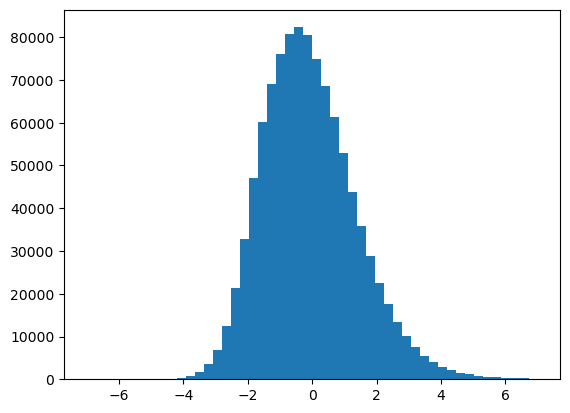

In [78]:
plt.hist(M_np1[~np.isnan(M_np1)], bins=50, range=(-7, 7))

## Temporal Histograms

In [79]:
RTC_MASK = WATER_MASK | np.isnan(arrs_vh_tv[0])
rows, cols = np.where(~RTC_MASK)

arrs_vh_tv[0][rows[100], cols[100]]

0.0045466865

In [80]:
np.random.seed(0)
N_SAMPLES = 400

In [81]:
N = 300
assert N < N_SAMPLES

In [82]:
K = np.random.randint(len(rows), size=N_SAMPLES)[N]
m, n = rows[K], cols[K]

arrs_vh_tv[0][m, n]

0.0068835565

<>:2: SyntaxWarning: invalid escape sequence '\m'
<>:2: SyntaxWarning: invalid escape sequence '\m'
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_17465/329436498.py:2: SyntaxWarning: invalid escape sequence '\m'
  plt.title('Temporal Differences of $X_{i} - \mu_n$ for all $i$')


(array([ 4.,  3., 18., 42., 29., 10.,  3.,  1.,  2.,  2.]),
 array([-2.4642725 , -1.83464348, -1.20501435, -0.57538533,  0.05424375,
         0.68387282,  1.31350183,  1.94313097,  2.57276011,  3.202389  ,
         3.83201814]),
 <BarContainer object of 10 artists>)

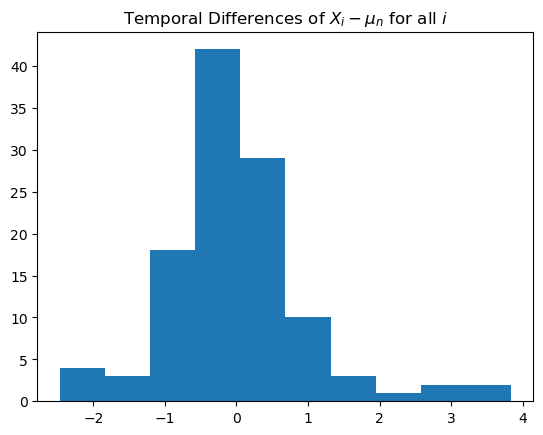

In [83]:
ts = ts_prev_norm[m, n, :]
plt.title('Temporal Differences of $X_{i} - \mu_n$ for all $i$')
plt.hist((ts - mu_n[m, n]) / sigma_n[m, n])

# Empirical modification

The only thing that seems normal is the $X_{n+1} - \mu_n$. Maybe the right standard deviation to scale by is determined over all valid pixels (particularly if we are considering only the correct land cover class).

In [84]:
#diffs = (ts_prev_norm - mu_n[..., np.newaxis])

# M_np1_mod = (time_series_arrs_norm[-1] - mu_all) / std_all
M_np1_mod = diff / std_all

<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\|'
<>:5: SyntaxWarning: invalid escape sequence '\m'
<>:10: SyntaxWarning: invalid escape sequence '\s'
<>:25: SyntaxWarning: invalid escape sequence '\m'
<>:31: SyntaxWarning: invalid escape sequence '\|'
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_17465/889011955.py:5: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title('$\mu_{n}$')
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_17465/889011955.py:10: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title('$\sigma_{n}$')
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_17465/889011955.py:25: SyntaxWarning: invalid escape sequence '\m'
  ax.set_title('$X_{n+1} - \mu_n$')
/var/folders/0p/d5x2m4tx5kg1246bplsvyfyh0000gq/T/ipykernel_17465/889011955.py:31: SyntaxWarning: invalid escape sequence '

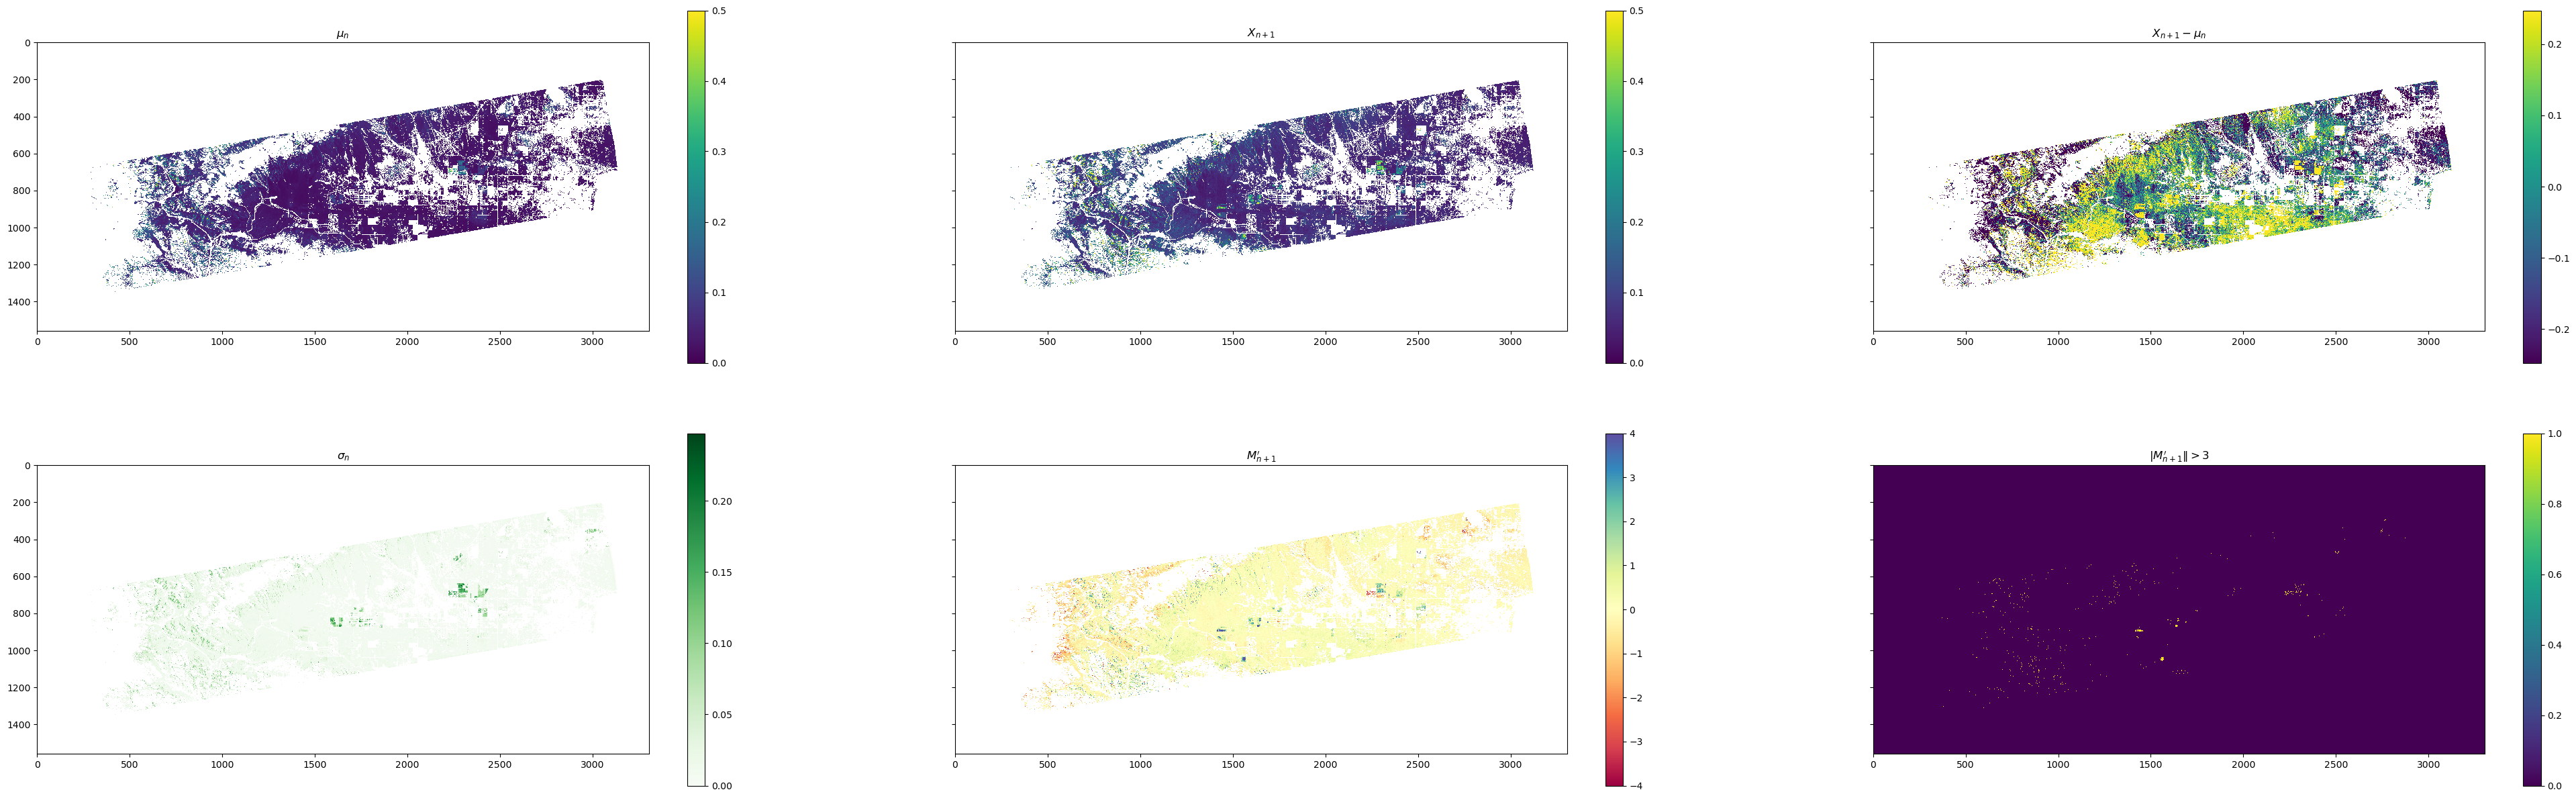

In [86]:
fig, axs = plt.subplots(2, 3, figsize=(50,15), sharey=True, dpi=100)

b_vmax = .5
ax = axs[0, 0]
ax.set_title('$\mu_{n}$')
im = ax.imshow(mu_n, vmin=0, vmax=b_vmax, interpolation='none')
fig.colorbar(im, ax=ax)

ax = axs[1, 0]
ax.set_title('$\sigma_{n}$')
im = ax.imshow(sigma_n, cmap='Greens', interpolation='none')
fig.colorbar(im, ax=ax)

ax = axs[0, 1]
ax.set_title('$X_{n+1}$')
im = ax.imshow(time_series_arrs[-1], vmin=0, vmax=b_vmax, interpolation='none')
fig.colorbar(im, ax=ax)

ax = axs[1, 1]
ax.set_title('$M_{n+1}\'$')
im = ax.imshow(M_np1_mod, vmin=-4, vmax=4, cmap='Spectral', interpolation='none')
fig.colorbar(im, ax=ax)

ax = axs[0, 2]
ax.set_title('$X_{n+1} - \mu_n$')
s_max = np.nanmax(sigma_n)
im = ax.imshow(M_np1_mod, vmin=-s_max, vmax=s_max, interpolation='none')
fig.colorbar(im, ax=ax)

ax = axs[1, 2]
ax.set_title('$|M_{n+1}\'\| > 3$')
im = ax.imshow(np.abs(M_np1_mod) > 3, interpolation='none')
fig.colorbar(im, ax=ax)